## Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

names = [*(f'col_{i}' for i in range(1,14)), 'target']
train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                       header=None, names=names)
val_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', 
                     skiprows=1, header=None, names=names)
val_df['target'] = val_df['target'].str[:-1]

# Run label encoder on all categorical columns
for column in train_df.columns:
    if train_df[column].dtype == 'object':
        le = LabelEncoder()
        le.fit(pd.concat([train_df[column], val_df[column]]))
        train_df[column] = le.transform(train_df[column])
        val_df[column] = le.transform(val_df[column])

## Create Dataset

In [3]:
from mlchecks import Dataset
from mlchecks.checks.overfit.boosting_overfit import boosting_overfit


train_ds = Dataset(train_df, label='target')
validation_ds = Dataset(val_df, label='target')


## Classification model

In [4]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(train_ds.features_columns(), train_ds.label_col())

AdaBoostClassifier()

In [5]:
validation_ds.data

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,target
25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0
38,4,89814,11,9,2,5,0,4,1,0,0,50,39,0
28,2,336951,7,12,2,11,0,4,1,0,0,40,39,1
44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,1
18,0,103497,15,10,4,0,3,4,0,0,0,30,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,4,215419,9,13,0,10,1,4,0,0,0,36,39,0
64,0,321403,11,9,6,0,2,2,1,0,0,40,39,0
38,4,374983,9,13,2,10,0,4,1,0,0,50,39,0
44,4,83891,9,13,0,1,3,1,1,5455,0,40,39,0


Segment Performance

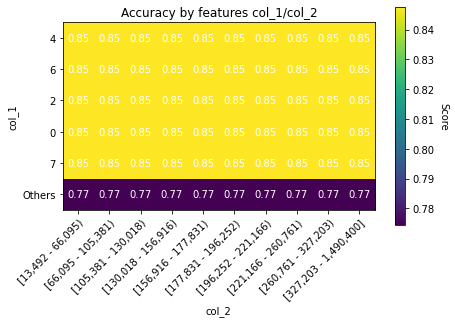

In [11]:
from mlchecks.checks.performance.segment_performance import segment_performance

segment_performance(validation_ds, clf, feature_1='col_1', feature_2='col_2')